In [595]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm
from scipy import stats

import  warnings
warnings.simplefilter('ignore')

### Import data

In [596]:
# import data
df_origin = pd.read_excel('MuMu Live Data 2021.xlsx')

In [597]:
df_origin.shape

(112, 41)

In [598]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Live Num                                     112 non-null    int64         
 1   Start Time (EST)                             112 non-null    datetime64[ns]
 2   Live Title                                   112 non-null    object        
 3   Store Name                                   112 non-null    object        
 4   City                                         112 non-null    object        
 5   Host                                         112 non-null    object        
 6   Host Type                                    112 non-null    object        
 7   Live Duration (min)                          112 non-null    int64         
 8   Total Live UV                                111 non-null    float64       
 9  

In [599]:
df_origin.head()

,Live Num,Start Time (EST),Live Title,Store Name,City,Host,Host Type,Live Duration (min),Total Live UV,EN Total UV,...,Users Adding Products to Shopping Cart,EN Users Adding Products to Shopping Cart,Total GMV (approx $),EN GMV $,Orders,EN Orders,Products Sold,Buyers,User Placing First Orders,Product Upload
0,36626,2021-12-27 20:59:51,🇯🇵OSAKA: DESIGNER BAGS ON SALE,T@k-In Osaka,Osaka,MuMu,Platform,250,2905.0,2186,...,74,69,19377.00,18412.04,41,38.0,44,31,11,115
1,36520,2021-12-26 21:59:34,TOKYO🇯🇵: TIFFANY&CO + AUCTION,ALLU Shinsaibashi,Osaka,MuMu,Platform,240,3977.0,3192,...,19,18,18442.06,16443.55,79,64.0,79,28,5,80
2,36563,2021-12-25 21:00:31,🇯🇵OSAKA: DESIGNER BAG DEALS,T@k-In Osaka,Osaka,MuMu,Platform,211,1932.0,1296,...,69,61,34831.97,31427.10,57,53.0,58,32,7,118
3,36546,2021-12-25 10:00:14,🇯🇵TOKYO: DESIGNER DEALS IN RIZ,RIZ Shinsaibashi,Osaka,MuMu,Platform,286,2015.0,1490,...,49,43,22340.49,21393.60,40,37.0,42,17,5,111
4,36516,2021-12-24 20:59:34,OSAKA🇯🇵: VINTAGE DEALS @HEDY,Hedy Osaka,Osaka,MuMu,Platform,154,1337.0,766,...,22,20,3972.70,2603.40,6,4.0,6,6,1,59


### Handing missing values

In [600]:
# drop 3 missing values since its small size
df_origin = df_origin.dropna()

In [601]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Live Num                                     109 non-null    int64         
 1   Start Time (EST)                             109 non-null    datetime64[ns]
 2   Live Title                                   109 non-null    object        
 3   Store Name                                   109 non-null    object        
 4   City                                         109 non-null    object        
 5   Host                                         109 non-null    object        
 6   Host Type                                    109 non-null    object        
 7   Live Duration (min)                          109 non-null    int64         
 8   Total Live UV                                109 non-null    float64       
 9  

### Basic EDA and Preprocessing

In [602]:
print(df_origin['Start Time (EST)'].dt.time.min())
print(df_origin['Start Time (EST)'].dt.time.max())

10:00:14
23:01:27


In [603]:
df_origin['Start Time (EST)'][df_origin['Start Time (EST)'].dt.hour < 20]

3   2021-12-25 10:00:14
Name: Start Time (EST), dtype: datetime64[ns]

In [604]:
df_origin['Start Time (EST)'][df_origin['Start Time (EST)'].dt.hour > 22]

61   2021-09-16 23:01:27
62   2021-09-11 23:00:35
64   2021-09-08 23:00:03
Name: Start Time (EST), dtype: datetime64[ns]

<AxesSubplot:xlabel='Start Time (EST)'>

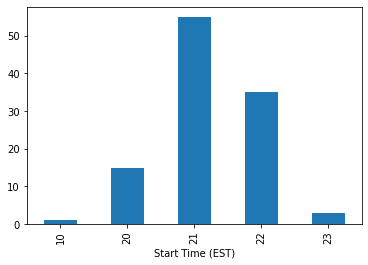

In [605]:
df_origin['Start Time (EST)'].groupby(df_origin['Start Time (EST)'].dt.hour).count().plot(kind="bar")

**For host's start time, only once before 8 pm and 3 times after 10 pm among 109 record, so start time figure is not useful as indicator since it's not representative.**

**For live title, we can extract the important word, such as verbs, and count the number of important word as a feature, or measure the length of the full phrase as a feature. However, since it's involves NLP techniques we will ignore it for now.**

**As a result, we will keep those meaningful/useful numerical features (total number if available for those divided by EN/CN) for analyses. And we will use Total GMV ($) as the definition of success/better performance.**

In [606]:
selectedfeatures = ['Host Type', 'Live Duration (min)', 'Total Live UV', 'EN New UV', 'EN Avg Watch Time (s)', 'Cumulative Views', 'Max Concurrent Viewers', 
                    'Subscribed EN Viewers', 'Subscribed CN Viewers', 'EN Viewers Who Follow You', 'CN Viewers Who Follow You', 'Comments', 'Commented Viewers', 'Product Clicks', 
                    'New EN Followers', 'New CN Followers', 'Products Added to Shopping Cart','Users Adding Products to Shopping Cart', 'Product Upload', 'Total GMV (approx $)']

df = df_origin[selectedfeatures]
df

,Host Type,Live Duration (min),Total Live UV,EN New UV,EN Avg Watch Time (s),Cumulative Views,Max Concurrent Viewers,Subscribed EN Viewers,Subscribed CN Viewers,EN Viewers Who Follow You,CN Viewers Who Follow You,Comments,Commented Viewers,Product Clicks,New EN Followers,New CN Followers,Products Added to Shopping Cart,Users Adding Products to Shopping Cart,Product Upload,Total GMV (approx $)
0,Platform,250,2905.0,652,806.34,21443,149,81,12,1018,252,1979,427,9100,196,16,162,74,115,19377.00
1,Platform,240,3977.0,1319,374.31,17901,159,174,29,1361,275,2087,325,3295,707,80,32,19,80,18442.06
2,Platform,211,1932.0,309,1029.79,16451,132,56,6,694,234,2065,287,7874,149,20,157,69,118,34831.97
3,Platform,286,2015.0,309,752.22,10156,112,23,6,717,170,1804,215,3559,132,15,90,49,111,22340.49
4,Platform,154,1337.0,252,594.11,6646,53,45,12,451,225,588,144,2125,133,23,39,22,59,3972.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Personal,62,212.0,4,95.86,626,11,1,8,7,14,99,12,134,0,4,2,1,18,159.86
106,Personal,91,341.0,8,143.89,843,9,2,7,9,15,66,10,86,1,4,1,1,7,46.57
107,Personal,131,500.0,12,38.02,1263,9,3,7,12,19,370,13,227,2,6,6,3,13,359.52
108,Personal,78,535.0,13,77.53,1316,17,2,13,13,18,71,10,126,3,3,2,1,7,49.61


In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Host Type                               109 non-null    object 
 1   Live Duration (min)                     109 non-null    int64  
 2   Total Live UV                           109 non-null    float64
 3   EN New UV                               109 non-null    int64  
 4   EN Avg Watch Time (s)                   109 non-null    float64
 5   Cumulative Views                        109 non-null    int64  
 6   Max Concurrent Viewers                  109 non-null    int64  
 7   Subscribed EN Viewers                   109 non-null    int64  
 8   Subscribed CN Viewers                   109 non-null    int64  
 9   EN Viewers Who Follow You               109 non-null    int64  
 10  CN Viewers Who Follow You               109 non-null    int64 

In [608]:
df.describe()

,Live Duration (min),Total Live UV,EN New UV,EN Avg Watch Time (s),Cumulative Views,Max Concurrent Viewers,Subscribed EN Viewers,Subscribed CN Viewers,EN Viewers Who Follow You,CN Viewers Who Follow You,Comments,Commented Viewers,Product Clicks,New EN Followers,New CN Followers,Products Added to Shopping Cart,Users Adding Products to Shopping Cart,Product Upload,Total GMV (approx $)
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,163.798165,1065.256881,248.174312,670.528807,6863.651376,51.266055,49.412844,10.871560,282.935780,156.275229,964.458716,125.100917,2482.981651,160.385321,23.440367,40.302752,17.889908,64.183486,8141.175596
std,51.894084,764.724986,283.896788,390.184915,5137.559589,32.147704,58.791410,10.447489,294.262741,74.556326,687.999173,106.734175,1980.288358,243.803462,21.696318,47.590752,19.371294,40.616354,8459.431650
min,44.000000,72.000000,0.000000,14.000000,289.000000,6.000000,0.000000,0.000000,0.000000,6.000000,22.000000,5.000000,12.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000
25%,127.000000,533.000000,21.000000,449.990000,2196.000000,27.000000,4.000000,5.000000,39.000000,113.000000,370.000000,36.000000,846.000000,9.000000,11.000000,6.000000,4.000000,33.000000,705.660000
50%,156.000000,808.000000,132.000000,643.370000,6546.000000,47.000000,31.000000,8.000000,143.000000,168.000000,890.000000,98.000000,2012.000000,77.000000,17.000000,23.000000,11.000000,60.000000,5373.540000
75%,190.000000,1440.000000,374.000000,833.250000,9947.000000,66.000000,73.000000,13.000000,462.000000,213.000000,1354.000000,181.000000,3499.000000,216.000000,30.000000,60.000000,26.000000,84.000000,12929.220000
max,368.000000,3977.000000,1319.000000,2271.670000,21443.000000,159.000000,319.000000,81.000000,1361.000000,321.000000,3604.000000,537.000000,9100.000000,1593.000000,145.000000,258.000000,105.000000,218.000000,37139.240000


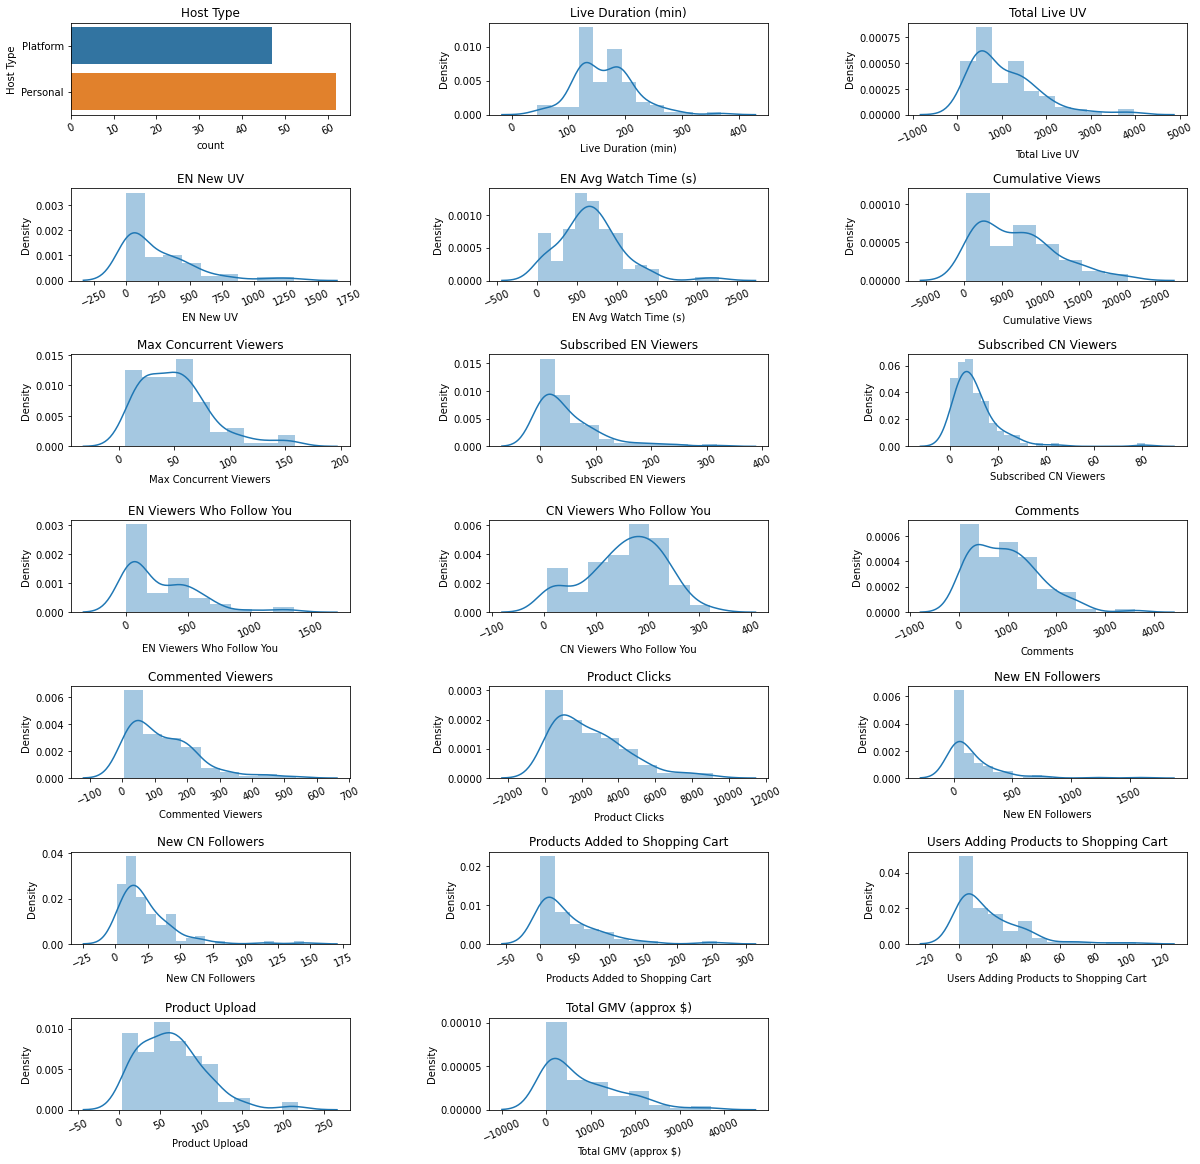

In [609]:
# plot distribution of each feature 

def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object: #Categorical
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else: #Numerical
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df, cols=3, width=20, height=20, hspace=0.8, wspace=0.5)

In [610]:
# plot correlation
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Live Duration (min),Total Live UV,EN New UV,EN Avg Watch Time (s),Cumulative Views,Max Concurrent Viewers,Subscribed EN Viewers,Subscribed CN Viewers,EN Viewers Who Follow You,CN Viewers Who Follow You,Comments,Commented Viewers,Product Clicks,New EN Followers,New CN Followers,Products Added to Shopping Cart,Users Adding Products to Shopping Cart,Product Upload,Total GMV (approx $)
Live Duration (min),1.00,0.79,0.65,0.29,0.81,0.77,0.55,0.11,0.75,0.80,0.83,0.77,0.78,0.59,0.58,0.73,0.80,0.76,0.73
Total Live UV,0.79,1.00,0.94,0.03,0.93,0.87,0.82,0.30,0.98,0.83,0.75,0.94,0.76,0.81,0.71,0.72,0.82,0.69,0.74
EN New UV,0.65,0.94,1.00,-0.05,0.85,0.76,0.90,0.32,0.95,0.74,0.67,0.91,0.66,0.85,0.73,0.63,0.71,0.62,0.65
EN Avg Watch Time (s),0.29,0.03,-0.05,1.00,0.22,0.28,-0.03,-0.07,0.02,0.26,0.31,0.11,0.40,-0.01,0.02,0.29,0.22,0.36,0.18
Cumulative Views,0.81,0.93,0.85,0.22,1.00,0.91,0.76,0.25,0.90,0.86,0.83,0.92,0.91,0.70,0.64,0.81,0.87,0.81,0.76
Max Concurrent Viewers,0.77,0.87,0.76,0.28,0.91,1.00,0.67,0.20,0.86,0.80,0.82,0.87,0.86,0.66,0.61,0.79,0.83,0.76,0.75
Subscribed EN Viewers,0.55,0.82,0.90,-0.03,0.76,0.67,1.00,0.44,0.81,0.70,0.61,0.89,0.60,0.78,0.66,0.59,0.64,0.64,0.53
Subscribed CN Viewers,0.11,0.30,0.32,-0.07,0.25,0.20,0.44,1.00,0.25,0.31,0.13,0.31,0.17,0.24,0.26,0.18,0.18,0.24,0.11
EN Viewers Who Follow You,0.75,0.98,0.95,0.02,0.90,0.86,0.81,0.25,1.00,0.79,0.71,0.94,0.73,0.84,0.69,0.71,0.81,0.66,0.75
CN Viewers Who Follow You,0.80,0.83,0.74,0.26,0.86,0.80,0.70,0.31,0.79,1.00,0.78,0.83,0.76,0.64,0.59,0.66,0.73,0.76,0.73


<AxesSubplot:>

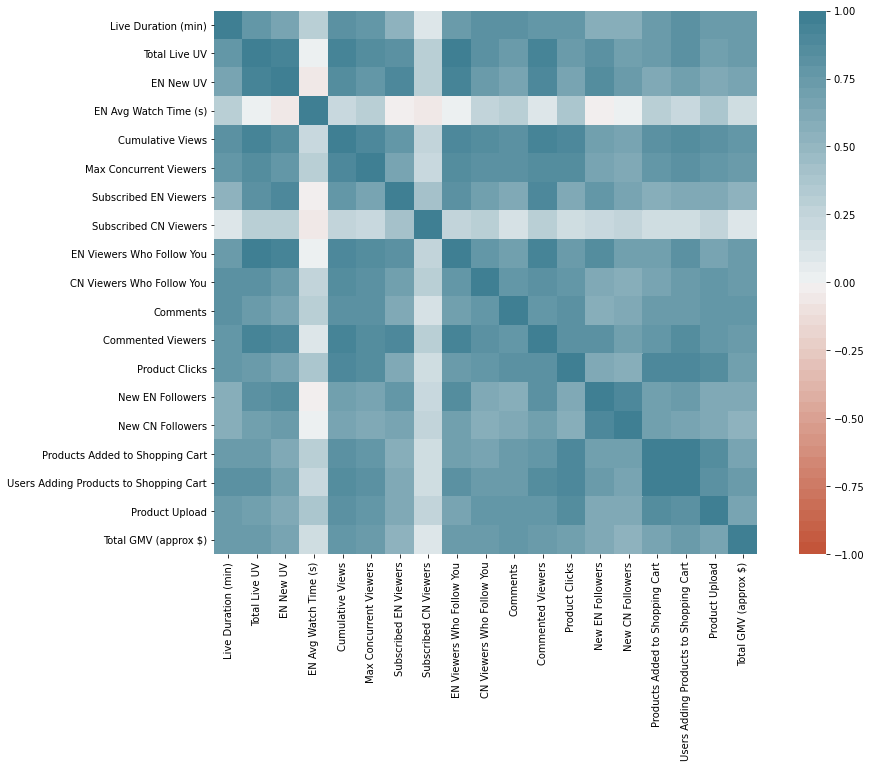

In [611]:
# heatmap
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=50), square=True)

**Linear Regression model**

In [612]:
#get dummies
df = pd.get_dummies(df, drop_first=True)

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 109
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Live Duration (min)                     109 non-null    int64  
 1   Total Live UV                           109 non-null    float64
 2   EN New UV                               109 non-null    int64  
 3   EN Avg Watch Time (s)                   109 non-null    float64
 4   Cumulative Views                        109 non-null    int64  
 5   Max Concurrent Viewers                  109 non-null    int64  
 6   Subscribed EN Viewers                   109 non-null    int64  
 7   Subscribed CN Viewers                   109 non-null    int64  
 8   EN Viewers Who Follow You               109 non-null    int64  
 9   CN Viewers Who Follow You               109 non-null    int64  
 10  Comments                                109 non-null    int64 

In [614]:
y = df['Total GMV (approx $)']
X = df.drop('Total GMV (approx $)', axis=1)

In [616]:
# add constant
X = sm.add_constant(X)

In [617]:
lr = sm.OLS(y, X)
lr_f = lr.fit()
print(lr_f.summary())

                             OLS Regression Results                             
Dep. Variable:     Total GMV (approx $)   R-squared:                       0.749
Model:                              OLS   Adj. R-squared:                  0.695
Method:                   Least Squares   F-statistic:                     13.96
Date:                  Fri, 06 May 2022   Prob (F-statistic):           3.70e-19
Time:                          18:03:44   Log-Likelihood:                -1064.6
No. Observations:                   109   AIC:                             2169.
Df Residuals:                        89   BIC:                             2223.
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

**Findings for feature importance**

**Based on the summary result, 'Comments' and 'Host Type_Platform' are the 2 features with significant coefficient p-value (<0.05). In another word, the number of comments and whether the host is broadcasting on platform are the more important indicators for success.**

**We will look into the relationship between number of comments and the Total GMV ($) to see if there is thresholds after which the performance will obviously improve.** 

In [618]:
df2 = df[['Comments', 'Total GMV (approx $)']]
df2.sort_values(['Comments'], ignore_index=True, inplace=True)
df2

,Comments,Total GMV (approx $)
0,22,0.00
1,41,0.00
2,52,40.01
3,66,46.57
4,71,49.61
...,...,...
104,2354,18955.49
105,2397,21211.91
106,2404,21281.45
107,2595,14499.84


<AxesSubplot:xlabel='Comments'>

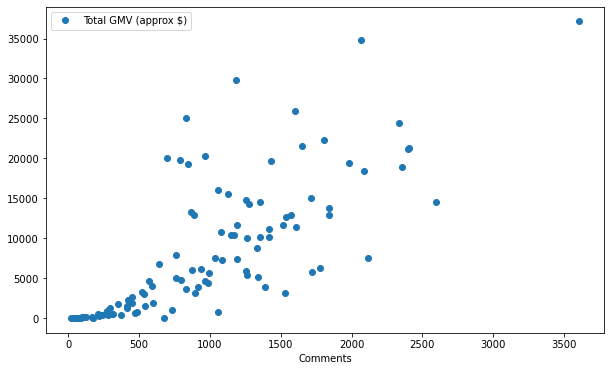

In [619]:
df2.plot(0,1,style='o', figsize=(10,6))

**We can clearly observe that after approximate 600 comments, the total GMV started to spread out with an overall significant uptrend.** 

In [620]:
df3 = df[['Comments', 'Live Duration (min)', 'Total GMV (approx $)']]
df3['Comments per Minute'] = df3['Comments'] / df3['Live Duration (min)']
df3.sort_values(['Comments per Minute'], ignore_index=True, inplace=True)
df3

,Comments,Live Duration (min),Total GMV (approx $),Comments per Minute
0,22,44,0.00,0.500000
1,52,90,40.01,0.577778
2,41,60,0.00,0.683333
3,66,91,46.57,0.725275
4,71,78,49.61,0.910256
...,...,...,...,...
104,1263,128,10030.05,9.867188
105,1531,150,3120.24,10.206667
106,2114,181,7552.94,11.679558
107,2404,185,21281.45,12.994595


<AxesSubplot:xlabel='Comments per Minute'>

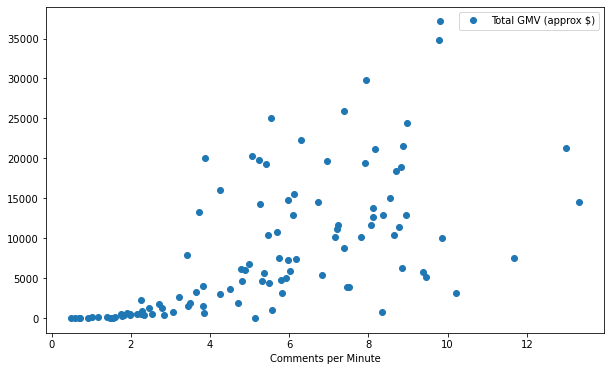

In [621]:
df3.plot('Comments per Minute', 'Total GMV (approx $)', style='o', figsize=(10,6))

**We can clearly observe that after 4 comments per minute, the total GMV started to spread out with an overall significant uptrend.** 

### Summary
* 'Comments' and 'Host Type_Platform' are the 2 indicators more important.
* After 600 comments or 4 comments per minute, the performance of the host, in terms of Total GMV, will obviously improve.